<a href="https://colab.research.google.com/github/RVel37/stats-UoM/blob/main/Day_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Data Science - Single Cell RNA sequencing analysis worksheet**

**Initial set up steps**

**1. Change Runtime type to T4 GPU**

**2. Mount your google drive to this google Co-lab session**

In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**3. Place the downloaded data 'Hufallopiantube.h5ad' into your google drive**
* You can drag and drop this from your downloads file, into the Files file icon on the left, and navigating to 'drive/MyDrive'


**4. Install additional required packages**

In [49]:
!pip install 'scanpy[leiden]'


**5. Import required packages**

In [50]:
import scanpy as sc
import seaborn as sns
import numpy as np
import pandas as pd
import anndata as ad # helpful if youw ant to e.g. merge two anndata datasets

AnnData = package for manipulating dataset (not needed for today)


# **1. AnnData as a data object** anndata.svg


We will explore a small single cell RNA sequencing dataset of Fallopian Tube cells. The dataset includes benign samples from 5 patients , and high grade serous ovarian carcinoma (HGOC) samples from 5 patients.

High-grade serous ovarian cancer (HGOC) is the most common and aggressive type of epithelial ovarian cancer.

It is hypothesised to originate from Serous tubal intraepithelial carcinoma (STIC) cells in the fallopian tube.


**1. Read in data to create an Anndata object**


In [51]:
hu = sc.read_h5ad('/content/drive/MyDrive/datascience_course/Hufallopiantube.h5ad')

**2. View the structure of the data**

In [52]:
hu.layers["counts"] = hu.X.copy()

**3. View the meta data**

In [53]:
hu

AnnData object with n_obs × n_vars = 4557 × 22109
    obs: 'Patient', 'Author', 'Tissue', 'Disease_stage', 'Age'
    layers: 'counts'

In [54]:
hu.obs

,Patient,Author,Tissue,Disease_stage,Age
CellID,,,,,
sc_b1_A08,33572,Hu_2020,Benign fallopian tube cells,Benign,64
sc_b1_B06,34350,Hu_2020,Benign fallopian tube cells,Benign,50
sc_b1_B08,34350,Hu_2020,Benign fallopian tube cells,Benign,50
sc_b1_B11,34350,Hu_2020,Benign fallopian tube cells,Benign,50
sc_b1_C15,34350,Hu_2020,Benign fallopian tube cells,Benign,50
...,...,...,...,...,...
15072R-p1-B17,15072,Hu_2020,HGSOC fallopian tube cells,IIIc1,62
15072R-p1-B18,15072,Hu_2020,HGSOC fallopian tube cells,IIIc1,62
15072R-p1-C01,15072,Hu_2020,HGSOC fallopian tube cells,IIIc1,62


In [55]:
hu.var

""
Gene
WASH7P
LOC729737
LOC100133331
LOC100288069
LINC00115
...
TXLNG2P
KDM5D
EIF1AY


**4. View the highest expressed genes**

  Using sc.pl.highest_expr_genes(data, n_top=int)

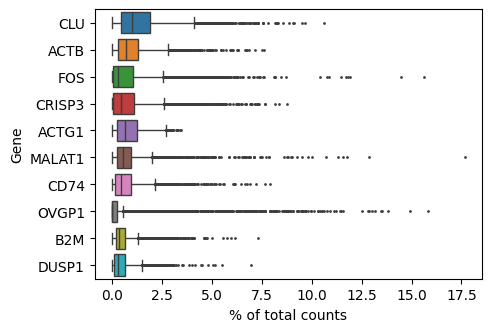

In [56]:
sc.pl.highest_expr_genes(hu, n_top = 10)

# **2. Filtering of the data**


**1. Filter out cells which have less than 100 genes expressed, and genes which are expressed in less than 3 cells.**

Use the scanpy commands:

* sc.pp.filter_cells(data, min_genes= *int*)
* sc.pp.filter_genes(data, min_cells= *int*)

removing any poor quality results (e.g. if there were dying or otherwise poor cells)

When filtering, scanpy computes:
For each cell (row in hu.X), Scanpy counts the number of genes with NON-ZERO expression in that cell.
--> "how many genes are detected at least once in this cell?"

This filter removes cells with FEWER THAN 10 DETECTED GENES, effectively removing poor quality cells.

(this uses raw counts, not normalised)


In [57]:
sc.pp.filter_cells(hu, min_genes=10)
sc.pp.filter_genes(hu, min_cells=10)

**2.Calculate quality control metrics**

This function doesn't filter anything; it computes summary statistics and stores them in the AnnData object.

`log1p = False` = use raw counts.

For each cell:
1. genes are ranked by expression within that cell
2. top 50 most highly expressed genes are selected
3. counts are summed
4. sum divided by cell's total counts
5. result stored as `pct_counts_in_top_50_genes`

* sc.pp.calculate_qc_metrics(data, percent_top=(50,
100,200,500),inplace=True, log1p=False, )

(replace the value in square brackets)

In [58]:
sc.pp.calculate_qc_metrics(hu,percent_top=[50], inplace=True, log1p=False, )

**3. View quality control metrics in a violin plot**
* sc.pl.violin(data, ['n_genes_by_counts','total_counts'],jitter=0.4, multi_panel=True)

POINT OF VIOLIN PLOT = SENSE CHECK.
Ideally, don't want really long tail like graph on the right - this shows a lot of genes w/ very few counts; should cut these off to delete the tail. This is why we filter cells further after.

Violin plot = distributions of numeric data for one or more groups using density curves. The width of each curve corresponds with the approximate frequency of data points in each region. Densities are frequently accompanied by an overlaid chart type, such as box plot, to provide additional information.

https://www.atlassian.com/data/charts/violin-plot-complete-guide#:~:text=A%20violin%20plot%20depicts%20distributions,plot%2C%20to%20provide%20additional%20information.


- LEFT violin plot = how many genes have been detected per cell
- RIGHT violin plot = raw counts (UMIs) per cell

Box plot

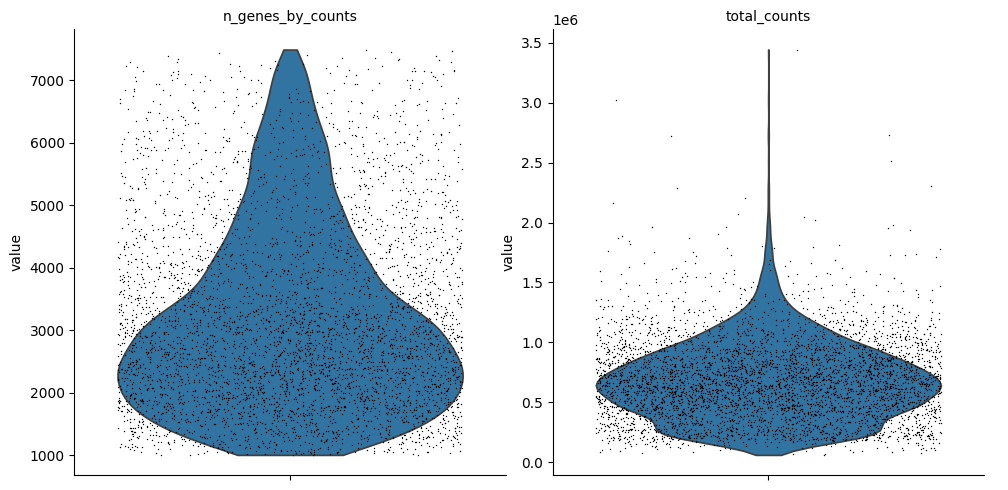

Text(0.5, 1.0, 'Total counts per cell')

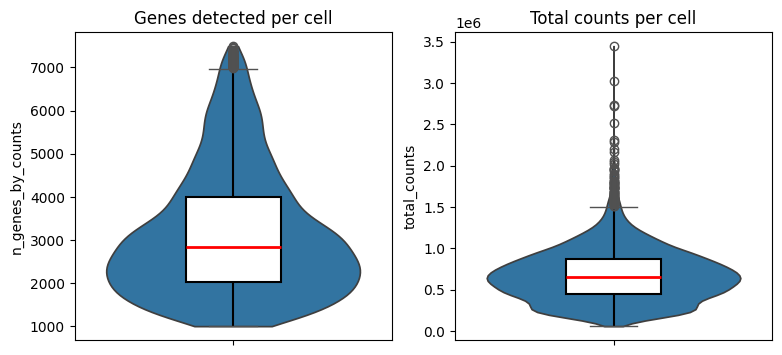

In [59]:
# option 1 - with "multi_panel" which controls how multiple variables are laid out(like 2 y axes)
sc.pl.violin(hu, ['n_genes_by_counts','total_counts'],jitter=0.4, multi_panel=True)

# option 2 - box plot
import seaborn as sns, matplotlib.pyplot as plt; fig, axes = plt.subplots(1, 2, figsize=(9,4))

sns.violinplot(y=hu.obs['n_genes_by_counts'], inner=None, cut=0, ax=axes[0]); sns.boxplot(y=hu.obs['n_genes_by_counts'], width=0.3, showcaps=True, boxprops=dict(facecolor='white', edgecolor='black', linewidth=1.5), medianprops=dict(color='red', linewidth=2), whiskerprops=dict(color='black', linewidth=1.5), ax=axes[0]); axes[0].set_title('Genes detected per cell')
sns.violinplot(y=hu.obs['total_counts'], inner=None, cut=0, ax=axes[1]); sns.boxplot(y=hu.obs['total_counts'], width=0.3, showcaps=True, boxprops=dict(facecolor='white', edgecolor='black', linewidth=1.5), medianprops=dict(color='red', linewidth=2), whiskerprops=dict(color='black', linewidth=1.5), ax=axes[1]); axes[1].set_title('Total counts per cell')


**4.Filter the cells further by slicing the anndata object on 'n_genes_by_counts' <6000 and 'total_counts' <1500000**

For n_genes_by_counts (remove cells with a high number of detected genes) this would be:
* data=data[data.obs.n_genes_by_counts <6000,:]

**NOTE**: there was originally a tail in the violin. This step (below code) removed it.
The WIDE part of the violin = where most cells are.
Thin tails = rare/extreme cells; we wanted to remove a tail which would have been poor quality cells.

1. we filter cells in tail of `n_genes_by_counts`. By removing this tail of the violin, we remove cells with unusually high numbers of genes (often doublets/multiplets), or occasionally highly damaged/over-sequenced artefacts.

Note: multiplets = droplets that contain more than 1 cell, but analysis pipeline thought they're one cell.

2. filter `total_counts` - cells with abnormally high UMI counts; again multiplets/technical amplification artefacts.


In [60]:
# filter cells in the tail of the n_genes_by_counts violin
hu=hu[hu.obs.n_genes_by_counts < 6000,:]

# filter total_counts over 1,500,000
hu=hu[hu.obs.total_counts < 1500000,:]

**5.View the structure of the data after filtering steps**

In [61]:
hu

View of AnnData object with n_obs × n_vars = 4231 × 18469
    obs: 'Patient', 'Author', 'Tissue', 'Disease_stage', 'Age', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'counts'

# **3.Dimensionality Reduction and visualisation**
To plot the data in a UMAP,


1. Initial pre-processing steps:
* Normalise the counts per cell, so each cell has 10,000 counts
* log transform the data

2.   Identify and crop the data to only the highly variable genes, then scale the data
3.   Compute the PCA
4.   Compute the Nearest neighbours graph
5.   Compute the UMAP




**1.Normalise and log transform the data**

Ensure samples are comparable - each patient is individual, so we need similar numbers of cells and genes for the data to be MEANINGFUL.

* sc.pp.normalize_total(data, target_sum=1e4)
* sc.pp.log1p(data)

In [77]:
sc.pp.normalize_total(hu,target_sum=1e4)
sc.pp.log1p(hu)

**2.Crop the data to highly variable genes only**
* sc.pp.highly_variable_genes(data, min_mean=0.0125, max_mean=3, min_disp=0.5)
* sc.pl.highly_variable_genes(data)
* data.raw = data
* data = data [:, data.var.highly_variable]
* sc.pp.scale(data, max_value=10)

(This data shows our highly variable genes; lecturer doesn't prefer this graph. Don't include.)

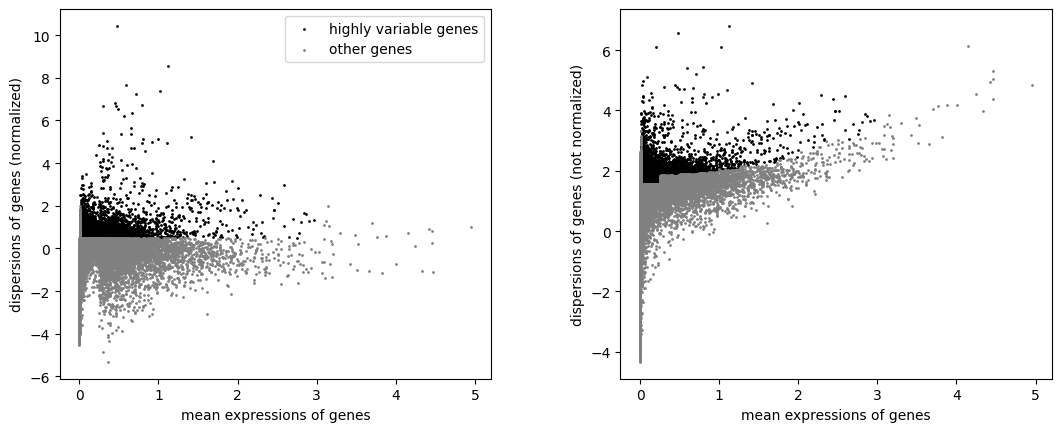

In [63]:
sc.pp.highly_variable_genes(hu, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(hu)

**3.Calculate and plot a principal component analysis (PCA) elbow plot**

PCA `color` variable can be anything we want from `hu` metadata.
To choose how many PCs we're using, we look at elbow plot - where there is a sharp turn, that represents roughly how many we should use to make sure we're capturing most of the variation (8 or 9 in this instance). There's also a scatter version of the elbow plot shown below.

(tl = "tool", pl = "plot")

* sc.tl.pca(data, svd_solver='arpack')
* sc.pl.pca_variance_ratio(data, log=True)
* sc.pl.pca(data, color=[' '])

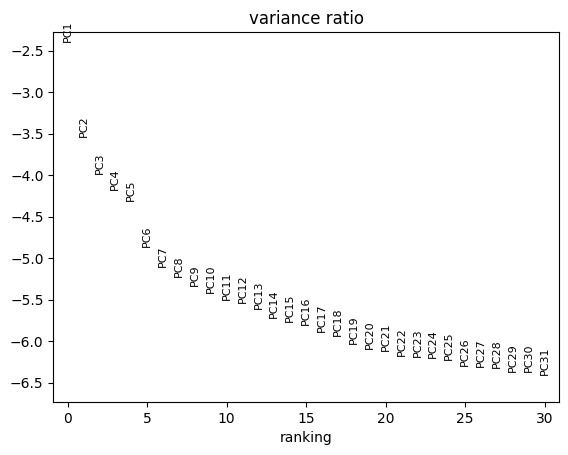

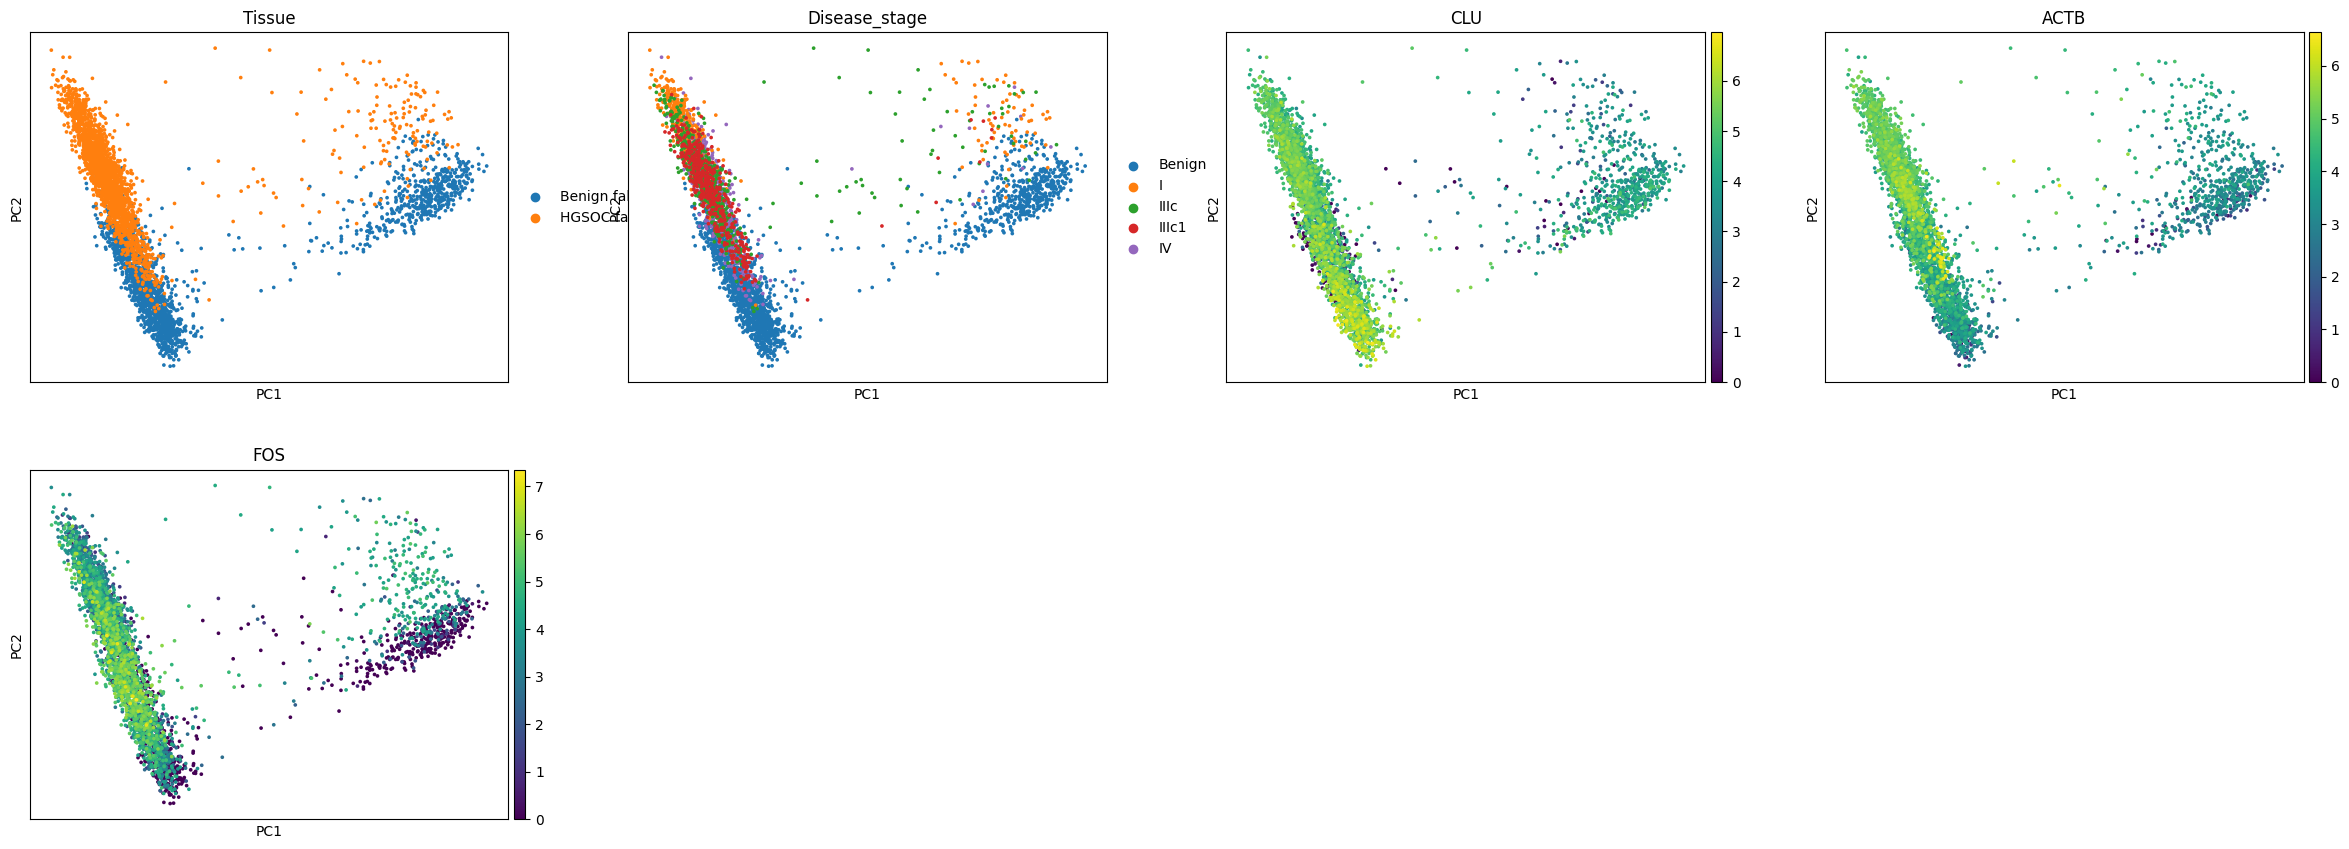

In [64]:
sc.tl.pca(hu, svd_solver='arpack')
sc.pl.pca_variance_ratio(hu, log=True)
sc.pl.pca(hu, color=['Tissue','Disease_stage','CLU','ACTB','FOS'])

**4.Compute the nearest neighbours graph, choose the number of principal components to use based on the elbow of the PCA plot (inflection point)**
 * sc.pp.neighbors(data, n_pcs= )

 This is where we choose no. of PCs to add. I picked 8.

In [105]:
sc.pp.neighbors(hu, n_pcs=8) # 8 = the elbow
 # looking at graph above this is where it takes a sharp turn from vertical ish to more horizontal. so we want to include the first 8 before this turn

**5.Compute and plot the UMAP**
* sc.tl.umap(data)

Plot the UMAP by Tissue, or another value of.obs columns
* sc.pl.umap(data, color=[''])

`tl` = tools (code to generate data)
`pl` = plot (code to generate graphs)

In [106]:
# see what metadata we have, which can be used as umap arg
hu.obs.columns

Index(['Patient', 'Author', 'Tissue', 'Disease_stage', 'Age', 'n_genes',
       'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes',
       'leiden'],
      dtype='object')

In [107]:
sc.tl.umap(hu)

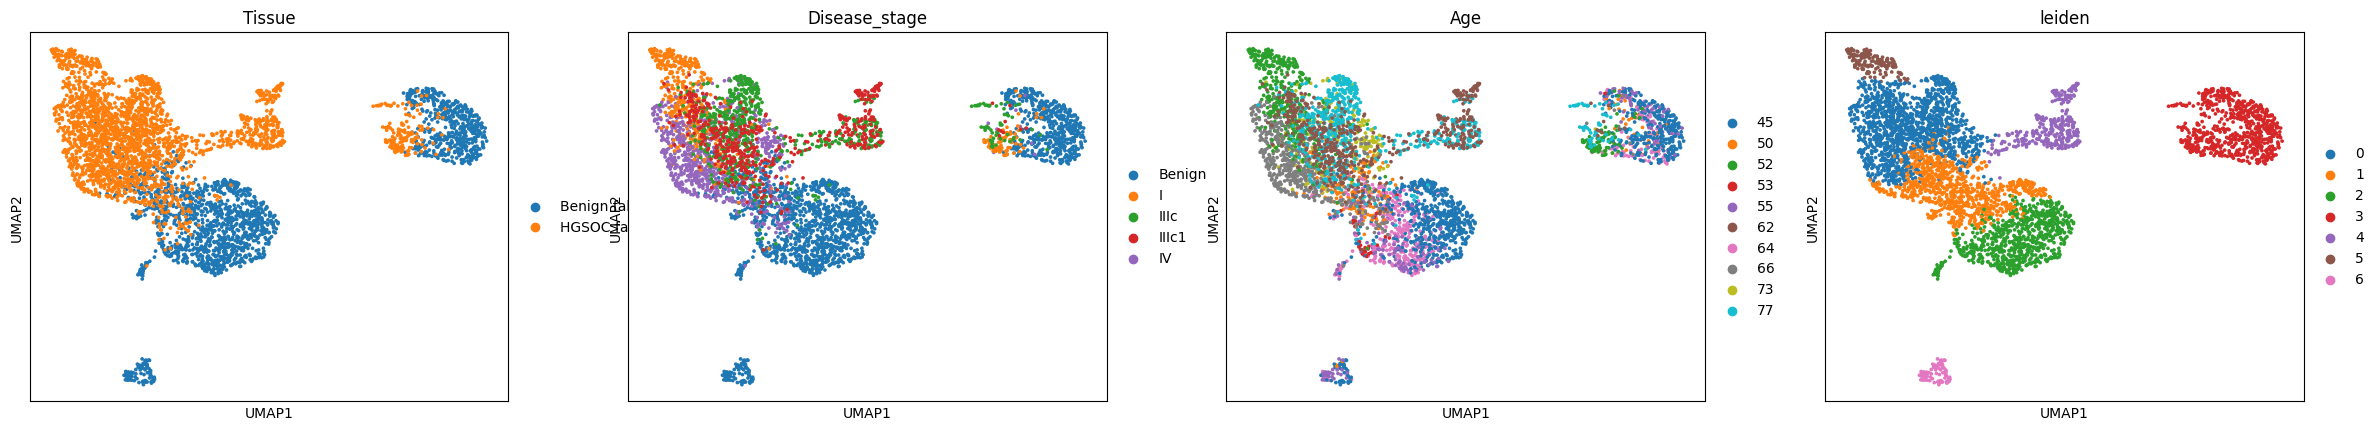

In [108]:
sc.pl.umap(hu, color=['Tissue','Disease_stage', 'Age','leiden'])

Well-clustered = distinct islands of cells, little overlap.
Poor clusters = diffuse, overlapping cells, no clear separation

- this is just visual sanity checking - not quantitative, but important for downstream analysis.

Very tiny clusters (<10-20 cells) maybe noise. Very large clusters  could  mask heterogeneity.

---
RESULTS INTERPRETATION
- Tissue forms "clean blobs" -> tissue is the DOMINANT DRIVER OF VARIATION in the dataset. Cells from same tissue are transcriptionally v similar, clustering tightly in the UMAP
- Disease stage = more subtle, weaker signal. (this is common - disease/treatment/etc are often secondary effects; shouldn't expect separate blobs for every disease stage.)


Plot the UMAP in the color of gene expression (use one of the genes from top 20 highly expressed genes)

Choose any gene and plot it to see

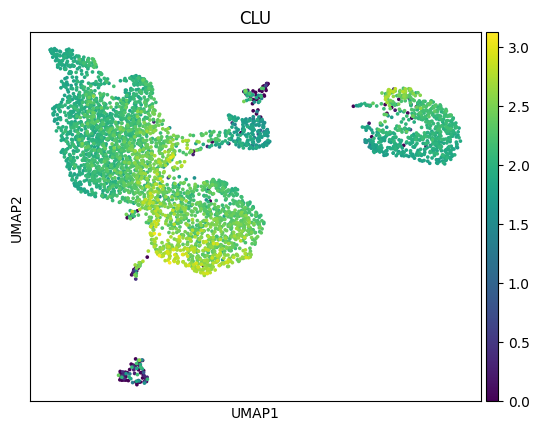

In [109]:
sc.pl.umap(hu, color = ['CLU'])

**6.Examine how the UMAP structure changes when you change the number of pcs used to generate the n_neighbours graph**

To visualise how this changes our data. (default n_neighbours was 15 - we can keep it that way as it looked good.)


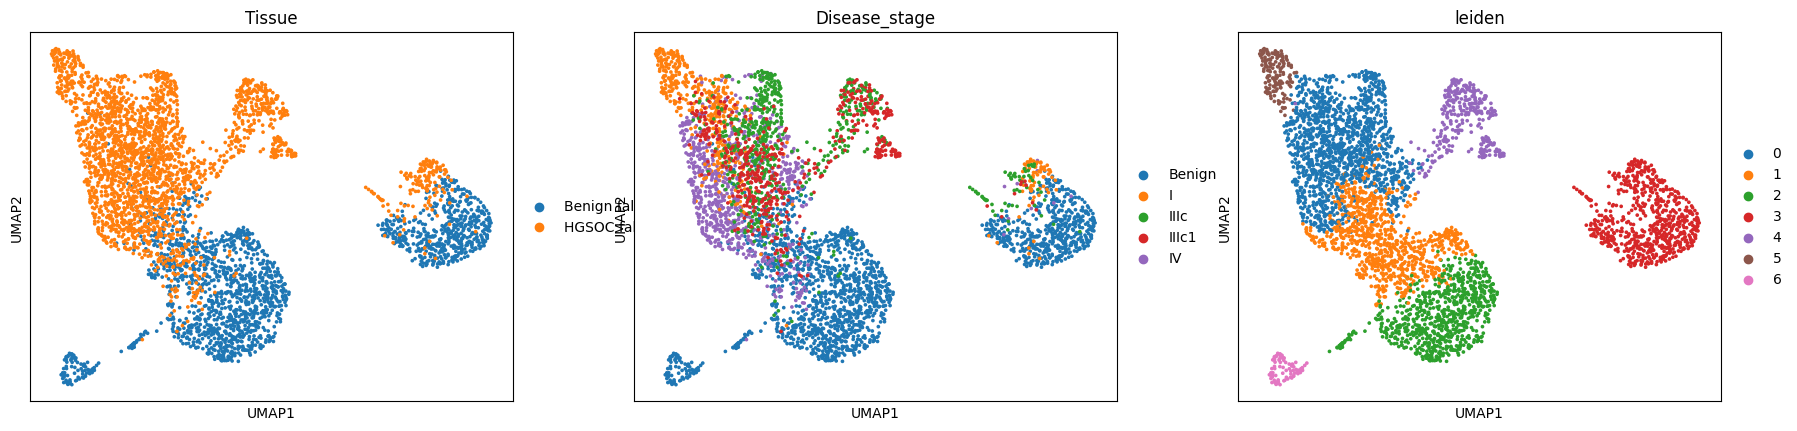

In [111]:
sc.pp.neighbors(hu, n_pcs=8, n_neighbors=20); sc.tl.umap(hu); sc.pl.umap(hu, color=['Tissue','Disease_stage','leiden'])

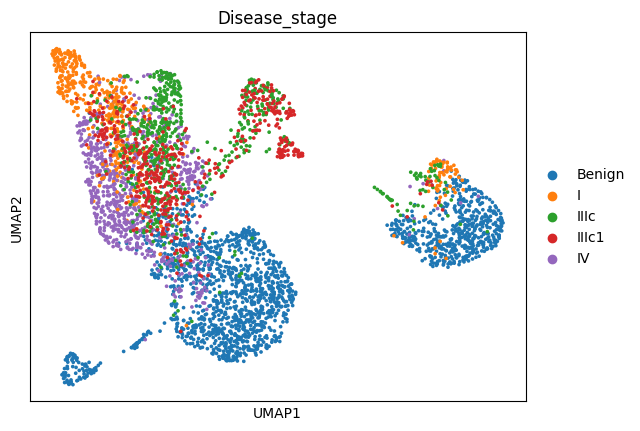

In [104]:
sc.pp.neighbors(hu, n_pcs=2)
sc.pl.umap(hu, color=['Disease_stage'])


**7. Re-run the nearest neighbours graph and UMAP with optimal number of PCs**

# **5.Leiden clustering**

This is the clustering algorithm Scanpy uses to decide WHICH CELLS BELONG TOGETHER ON A GRAPH. (clusters cells to identify similar groups)

Conceptually, Scanpy builds a KNN (k nearest neighbour) graph of cells, where each cell = node, edges connect cells w/ similar expression profiles, edge weights reflect simialrity.
Then, Leiden finds communities in that graph, maximises modularity and assigns each cell a CLUSTER LABEL.

Comparison to other tools:
- UMAP: “What does the data look like in 2D?”
- Leiden: “Where are the dense neighborhoods in expression space?”
- Marker genes: “What biology explains those neighborhoods?”

* By examining gene expression, determine what type of cells are in each cluster
* Using a dictionary, create a new obs. column assigning a label of cell type to leiden clusters
* Test the top differentially expressed genes in each leiden cluster/cell type
* Plot a heatmap of top differentially expressed genes in each leiden cluster/cell type

**1. Perform leiden clustering, then visualise clusters on the UMAP**
* sc.tl.leiden(data, resolution=0.2)
* sc.pl.umap(data, color=['leiden'])

/tmp/ipython-input-2636511636.py:1: FutureWarning: The `igraph` implementation of leiden clustering is *orders of magnitude faster*. Set the flavor argument to (and install if needed) 'igraph' to use it.
In the future, the default backend for leiden will be igraph instead of leidenalg. To achieve the future defaults please pass: `flavor='igraph'` and `n_iterations=2`. `directed` must also be `False` to work with igraph’s implementation.
  sc.tl.leiden(hu, resolution=0.2)


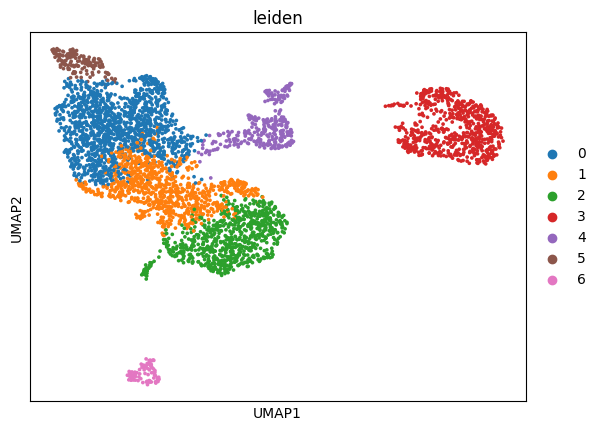

In [90]:
sc.tl.leiden(hu, resolution=0.2)
# resolution = param controlling no. of clusters in leiden algorithm.
# (controls granularity of clustering - not property of data)
sc.pl.umap(hu, color=['leiden'])
# leiden algorithm = search for high quality, stable clusters.
# (Popular for scRNA, graph based ML, and other stuff)

**2. Calculate the top differentially expressed genes in each leiden cluster**
 `sc.tl.rank_genes_groups(data,'leiden', method='wilcoxon')`
- Performing differential expression analysis to find marker genes for each Leiden cluster.
- `rank_genes_groups` = compare expression of each gene in 1 cluster vs all other cells. Identify **which genes are significantly upregulated in that cluster**
- `leiden` arg = clusters come from the leiden clustering. (Cluster 0 markers, cluster 1 markers...etc)

 `sc.pl.rank_genes_groups(data, n_genes=25)`

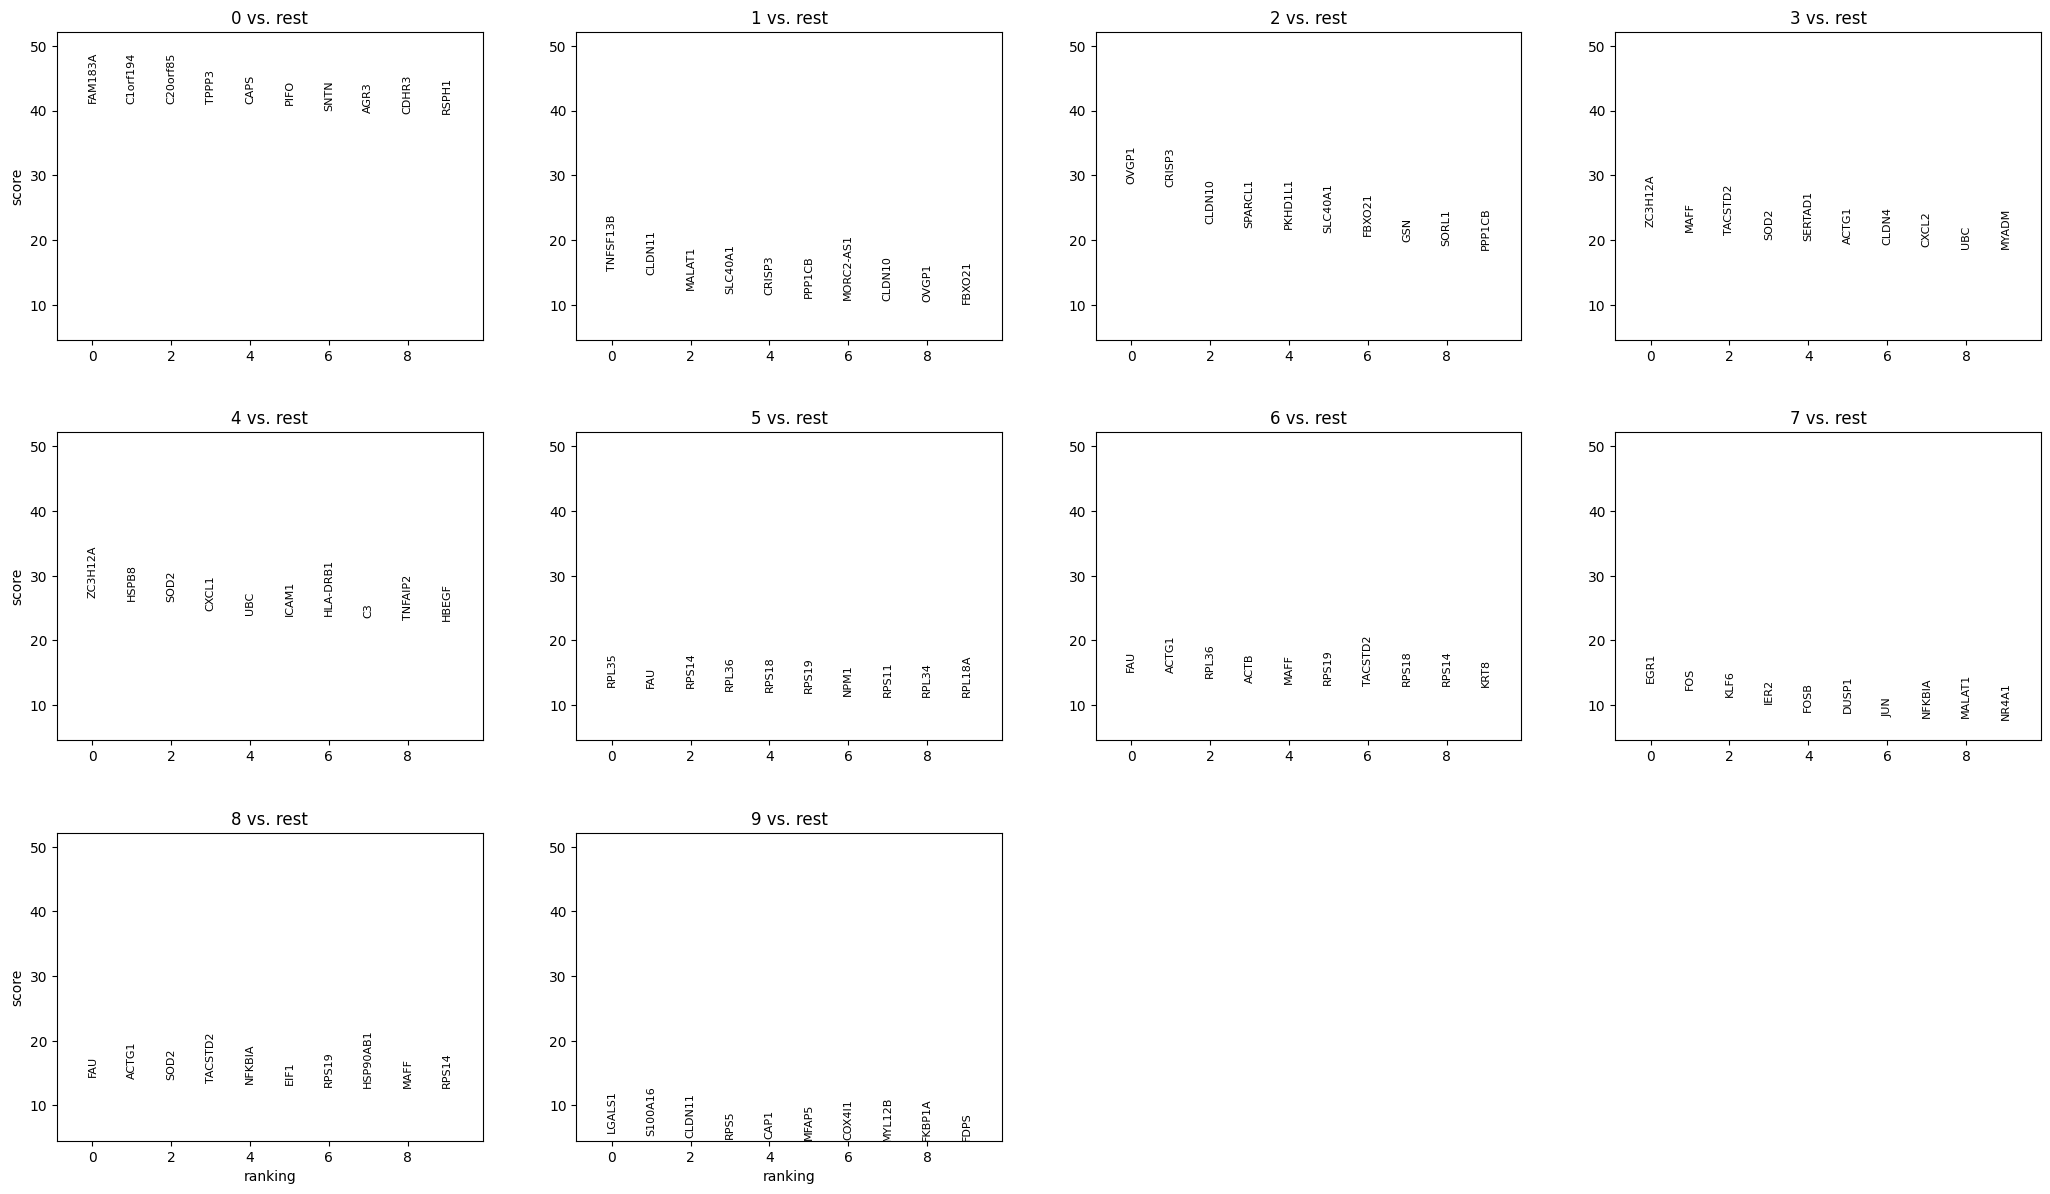

In [71]:
sc.tl.rank_genes_groups(hu,'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(hu,n_genes=10)

**3. Export the ranked genes, with scores to a csv file (we will come back to these tomorrow)**

In [72]:
topmarkers=hu.uns['rank_genes_groups']
groups = topmarkers['names'].dtype.names
celltypemarkergenes = pd.DataFrame({group +'_'+key[:1]:topmarkers[key][group]
              for group in groups for key in ['names','scores']})

celltypemarkergenes.to_csv(r'/content/drive/MyDrive/datascience_course/celltypemarkergenes.csv', index=False)

celltypemarkergenes

,0_n,0_s,1_n,1_s,2_n,2_s,3_n,3_s,4_n,4_s,5_n,5_s,6_n,6_s,7_n,7_s,8_n,8_s,9_n,9_s
0,FAM183A,41.162251,TNFSF13B,15.248298,OVGP1,28.696299,ZC3H12A,22.000374,ZC3H12A,26.633181,RPL35,12.837257,FAU,15.219006,EGR1,13.449960,FAU,14.521100,LGALS1,5.766312
1,C1orf194,41.123615,CLDN11,14.685778,CRISP3,28.216896,MAFF,21.260088,HSPB8,26.153866,FAU,12.688490,ACTG1,14.960337,FOS,12.444939,ACTG1,14.146316,S100A16,5.292525
2,C20orf85,41.069038,MALAT1,12.321927,CLDN10,22.583591,TACSTD2,20.833586,SOD2,25.992170,RPS14,12.629928,RPL36,14.284019,KLF6,11.346369,SOD2,14.020270,CLDN11,4.961283
3,TPPP3,41.052910,SLC40A1,11.659582,SPARCL1,21.900089,SOD2,20.067505,CXCL1,24.670105,RPL36,12.305774,ACTB,13.449547,IER2,10.282043,TACSTD2,13.554154,RPS5,4.837812
4,CAPS,41.032810,CRISP3,11.514584,PKHD1L1,21.812519,SERTAD1,19.942717,UBC,23.925138,RPS18,12.011360,MAFF,13.324678,FOSB,8.961401,NFKBIA,13.371710,CAP1,4.830351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18464,C17orf76-AS1,-34.842445,HSPH1,-18.149809,EIF1,-23.709286,TXNIP,-8.699844,MEIS1,-9.488476,HLA-L,-7.905034,MORC2-AS1,-9.463501,CYSTM1,-10.811944,SLC40A1,-8.855802,ZC3H12A,-7.725029
18465,RPL18A,-34.867897,CDKN1A,-18.306950,CDKN1A,-24.340212,MORC2-AS1,-10.204127,OVGP1,-9.919984,ODF3B,-7.914691,SLC40A1,-9.910694,SLC44A4,-10.856765,MORC2-AS1,-9.575098,C1orf63,-7.968512
18466,MSLN,-35.576206,DNAJA1,-19.292229,TUBB4B,-25.312340,PPP1CB,-12.033331,TNFSF13B,-10.991373,CLDN10,-8.036858,PPP1CB,-10.141613,IGFBP7,-10.909719,PPP1CB,-9.944716,SOD2,-8.240726
18467,RPS19,-35.964012,TUBB4B,-20.272980,DNAJB1,-25.346056,CLDN11,-12.188625,PPP1CB,-12.013136,TNFSF13B,-9.467586,CLDN11,-10.394485,DYNLL1,-10.945516,TNFSF13B,-10.640701,DUSP14,-8.247645


**3. Plot top 20 differentially expressed genes in a heatmap**

* sc.pl.rank_genes_groups_heatmap(data, n_genes=20, swap_axes=True, show_gene_labels=False, vmin=-3, vmax=3 )

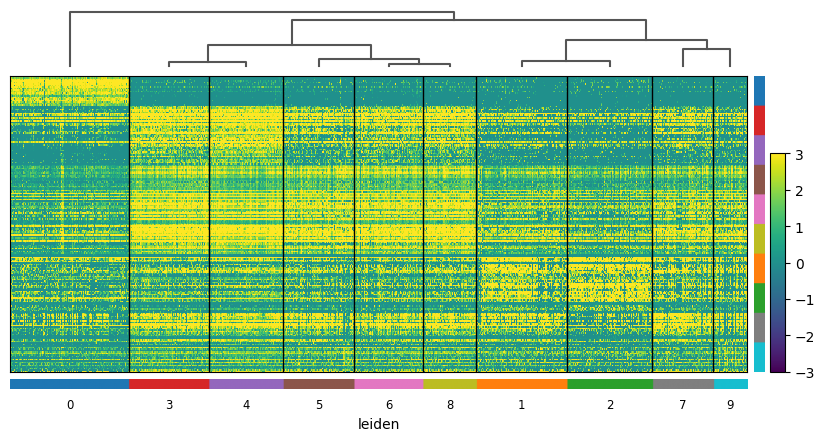

In [73]:
sc.pl.rank_genes_groups_heatmap(hu,n_genes=20, swap_axes=True, show_gene_labels=False, vmin=-3, vmax=3)
# vmin = value that maps to lowest colour (anything <= vmin appears in darkest colour)
# vice versa for vmax

**4. Visualise marker genes to determine the cell types present in each cluster**

Secretory Epithelial : OVGP1

Ciliated Epithelial : FOXJ1, PIFO

Immune: PTPRC

Fibroblast: COL1A1, DCN

STIC lesion : KRT17


* sc.pl.violin(data, ['EPCAM','OVGP1','...'], groupby = 'leiden')


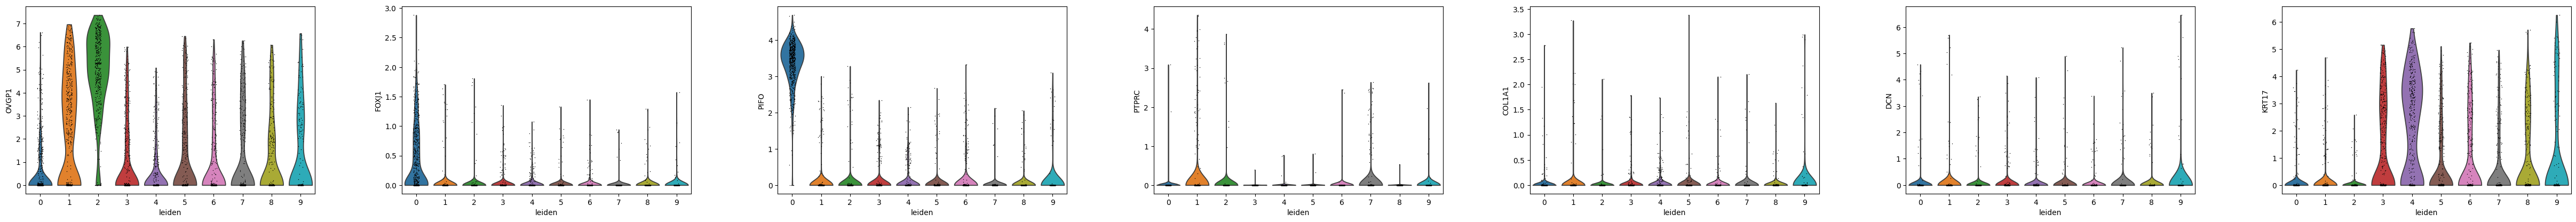

In [74]:
sc.pl.violin(hu, ['OVGP1', 'FOXJ1','PIFO','PTPRC','COL1A1', 'DCN', 'KRT17'], groupby='leiden')

**5. From these markers, it is still unclear what cell types some of the leiden clusters are**

Look up some of the top marker genes for these clusters to determine what cell types they are.

**6. Create a dictionary defining Leiden clusters and their respective cell type**

Create a new .obs column to store the cell types , and map this to leiden clusters using the dictionary,

Which cluster represents high grade carcinoma cells?

```
celltypedict = {
        '0' : 'Secretory Epithelial',
        '1' : 'Fibroblast' }

data.obs['Celltype'] = hu.obs['leiden'].map(celltypedict)


**7. Plot a UMAP colored by cell types**

KeyError: 'Could not find key Celltype in .var_names or .obs.columns.'

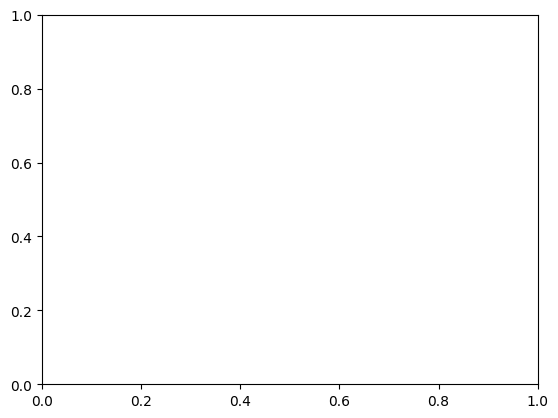

In [75]:
sc.pl.umap(hu, color=['Celltype'])

## **6. Querying GWAS catalog API**


As these women were diagnosed with ovarian cancers, we can use the GWAS catalog to look at the expression of genes associated with epithelial carcinomas

Use the packages: 'requests' and 'json'

Make a get request to the API for the association data from study no. GCST003588, the https address to use is "https://www.ebi.ac.uk/gwas/rest/api/studies/GCST003588/associations"





**3. We can use the GWAS catalog obtain a list of genes associated with high grade serous ovarian carcinoma**


In [ ]:
import requests
import json

In [ ]:
response=requests.get("https://www.ebi.ac.uk/gwas/rest/api/studies/GCST003588/associations")
response.json()

**4.Make a Pandas dataframe containing 'riskAlleleName' and 'geneName'**
* If you don't know how to do this, solution is in the 'geneIdsjson.py' file in the Github repository

In [ ]:
# start off with big json above

associations_data = response.json()['_embedded']['associations']
# pull GWAS associations list, and we are extracting _embedded -> associations
# which is a list, one item/GWAS association

gwas = pd.json_normalize(associations_data, 'loci')
# flatten loci list inside each association

risk_alleles = gwas.explode('strongestRiskAlleles').explode('authorReportedGenes').reset_index(drop=True)
# expand lists into long format.
# explode strongestriskalleles -> if locus has multiple alleles, one row per allele
# explode authorReportedGenes -> if multiple genes reported, one row per gene

risk_alleles_df = pd.json_normalize(risk_alleles['strongestRiskAlleles'])
# flatten the allele dictionary, to extract keys like 'riskAlleleName' and 'riskFrequency'
# and create DF

reportedgenes_df = pd.json_normalize(risk_alleles['authorReportedGenes'])
# flatten gene dictionary to extract geneName

gwasgenes=pd.concat([risk_alleles_df, reportedgenes_df], axis=1)
# combine allele + gene cols (merging both flattened pieces side by side)

gwasgenes = gwasgenes[['riskAlleleName', 'geneName']]
# keep just riskAlleleName + geneName

gwasgenes

**5. To plot the gene expression of carcinoma GWAS genes, convert this to a list**
* genes=[gene for gene in gwasgenes['geneName'].tolist() if gene !='Intergenic' and gene in hu.raw.var_names]

In [ ]:
genes=[gene for gene in gwasgenes['geneName'].tolist() if gene !='Intergenic' and gene in hu.var_names]
genes

**6. Plot gene expression of Carcinoma GWAS genes per leiden cluster in a dot plot**
* sc.pl.dotplot()


In [ ]:
sc.pl.dotplot(hu, genes, groupby='leiden', swap_axes=True, dendrogram=True)

**7. Plot gene expression of the highly expressed carcinoma GWAS genes in a UMAP, compare this to a UMAP of Disease Stage**

In [ ]:
sc.pl.umap(hu, color=['leiden','Disease_stage','TUBA1C','KRT8','HLA-C'])

# esp. with TUBA1C we can see that they are pretty much exclusively expressed in tumorous tissue (compare disease stage graph with tuba1c graph.)

## **6. Subsetting secretory epithelial cells**
As HGOC is thought to originate from epithelial cells in the fallopian tube, we can examine epithelial cells in greater depth by creating a subset of the data of epithelial cells.

**1. Create new object of a subset of epithelial cell data**
* subset = data[data.obs['Celltype'].isin([''])]

In [ ]:
subset=hu[hu.obs['Celltype'].isin(['Secretory Epithelial'])]
subset

**2. Run the dimensionality reduction and clustering analysis again to identify clusters of epithelial cells**

In [ ]:
pd.DataFrame(secretory.uns["rank_genes_groups"]["names"]).head(25)
